# Intro

This is a copy of the kernel I used to submit to Kaggle.

In [1]:
# Initial Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import calendar
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
from sklearn.metrics import cohen_kappa_score, make_scorer

In [2]:
%%time
# load the data
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')
specs = pd.read_csv('specs.csv')
sample_submission = pd.read_csv('sample_submission.csv')

CPU times: user 54.7 s, sys: 10.4 s, total: 1min 5s
Wall time: 1min 9s


### Train

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [5]:
train.describe()

,event_count,event_code,game_time
count,1.134104e+07,1.134104e+07,1.134104e+07
mean,1.056642e+02,3.513838e+03,1.976236e+05
std,1.483477e+02,6.816470e+02,1.803968e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.061800e+04
50%,6.100000e+01,4.020000e+03,7.276100e+04
75%,1.290000e+02,4.035000e+03,1.574460e+05
max,3.368000e+03,5.010000e+03,3.069102e+08


In [6]:
#  From Erik Bruin on Kaggle
# filter to only include installation_ids that have taken an assessment
keep_id = train[train.type == 'Assessment'][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on='installation_id', how='inner')
del keep_id
train.shape

(8294138, 11)

In [7]:
train['installation_id'].nunique()

4242

In [8]:
# reassign the column with a conversion of its value to dateitme
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8294138 entries, 0 to 8294137
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          datetime64[ns, UTC]
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 759.4+ MB


Let's take a look at the event_data.

In [10]:
train['event_data'].head()

0               {"event_code": 2000, "event_count": 1}
1               {"event_code": 2000, "event_count": 1}
2    {"version":"1.0","event_count":1,"game_time":0...
3    {"description":"Let's build a sandcastle! Firs...
4    {"coordinates":{"x":273,"y":650,"stage_width":...
Name: event_data, dtype: object

It looks like they all have different fields within the JSON.

In [11]:
train['event_data'][0]

'{"event_code": 2000, "event_count": 1}'

In [12]:
train['event_data'][2]

'{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}'

In [13]:
train['event_data'][3]

'{"description":"Let\'s build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","total_duration":6758,"event_count":2,"game_time":29,"event_code":3010}'

In [14]:
train['event_data'][4]

'{"coordinates":{"x":273,"y":650,"stage_width":1015,"stage_height":762},"event_count":3,"game_time":2137,"event_code":4070}'

In [15]:
train['title'].value_counts()

Bottle Filler (Activity)         723291
Scrub-A-Dub                      694933
Chow Time                        620809
Sandcastle Builder (Activity)    570611
Fireworks (Activity)             397510
Crystals Rule                    382885
Bug Measurer (Activity)          373732
Bubble Bath                      353482
Dino Dive                        336200
Dino Drink                       330756
Pan Balance                      329547
Chicken Balancer (Activity)      320029
All Star Sorting                 316791
Flower Waterer (Activity)        290728
Happy Camel                      264375
Air Show                         261229
Watering Hole (Activity)         254266
Leaf Leader                      234865
Egg Dropper (Activity)           209536
Mushroom Sorter (Assessment)     199595
Chest Sorter (Assessment)        190318
Bird Measurer (Assessment)       190164
Cauldron Filler (Assessment)     181925
Cart Balancer (Assessment)       163343
Magma Peak - Level 2               9673


In [16]:
train['type'].value_counts()

Game          4125872
Activity      3139703
Assessment     925345
Clip           103218
Name: type, dtype: int64

In [17]:
train['event_code'].value_counts()

4070    1654774
4030    1119471
3010    1032834
3110    1015520
4020     918446
2020     262918
2030     227063
4035     204074
4025     202545
3020     198915
3120     196424
2000     195445
3021     190649
3121     187075
4021     118538
4040      79165
4100      65073
4022      54461
4010      38979
4031      32641
4230      24806
4235      24801
2080      24418
2040      23225
2050      20477
2083      16741
4045      16314
5000      15661
2025      15658
4220      15349
5010      15323
4110      13308
2060      12344
2010      11694
4095      10487
2035       9632
4090       9063
2081       6181
2070       6074
2075       5365
4050       1586
4080        621
Name: event_code, dtype: int64

There are a lot of event_codes, many which are not clear as to what they do mean. We do know, that event_code 2000 is treated as a start. 4100, is the code for an assessment attempt for all assessments other than Bird Measurer, which records the assessment attempt in 4110.

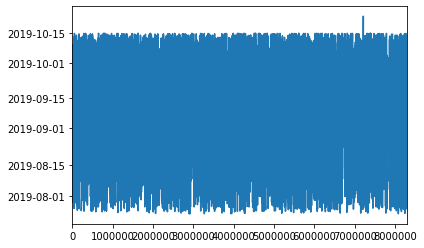

In [18]:
train['timestamp'].plot()

In [19]:
train['world'].value_counts()

MAGMAPEAK       3464962
TREETOPCITY     2453170
CRYSTALCAVES    2368013
NONE               7993
Name: world, dtype: int64

### Train Labels

In [20]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [21]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [22]:
train_labels['installation_id'].nunique()

3614

In [23]:
# create a list of unique installation ids in train_labels
unique_ids_train_labels = list(train_labels['installation_id'].unique())
# filter the train dataset for values whose installation_id appears in train_labels
train = train[train['installation_id'].isin(unique_ids_train_labels)]
# delete unique_ids_train_labels to save memory
del unique_ids_train_labels
# check the number of unique installation_ids in train
train['installation_id'].nunique()

3614

In [24]:
train.shape

(7734558, 11)

In [25]:
train_labels['game_session'].value_counts()

034be5ea5bb89759    1
82531aac3c500b2f    1
9d7924c2d9abb9ad    1
ac9e28ea0875ef9e    1
9b6f9d8888290646    1
                   ..
29b0573ef2b76725    1
474e91e7f57234f4    1
445aa4baa61c71c1    1
84015bd232d29ff8    1
5b4c26e8e64ab2c5    1
Name: game_session, Length: 17690, dtype: int64

In [26]:
train_labels['installation_id'].value_counts()

08987c08    156
f1c21eda    129
9f399a3a     78
8e44d2de     72
123a40a1     64
           ... 
7f806609      1
6cc7ae2e      1
d04adc67      1
01120f12      1
b406112e      1
Name: installation_id, Length: 3614, dtype: int64

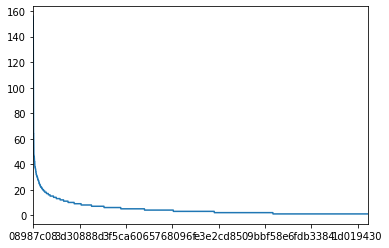

In [27]:
installation_id_attempts = train_labels['installation_id'].value_counts()
installation_id_attempts.plot();

In [28]:
train_labels.describe()

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


In [29]:
train_labels['accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

## Test

Let's take a look at the test data.

In [30]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: int64(3), object(8)
memory usage: 97.1+ MB


In [32]:
test.describe()

,event_count,event_code,game_time
count,1.156414e+06,1.156414e+06,1.156414e+06
mean,1.107075e+02,3.514353e+03,1.869646e+05
std,2.193408e+02,6.802671e+02,1.670162e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.056125e+04
50%,6.000000e+01,4.020000e+03,7.102800e+04
75%,1.240000e+02,4.035000e+03,1.476910e+05
max,4.456000e+03,5.010000e+03,8.859842e+07


The testing data looks the same as the training data. This means we will have to perform similar operations as the training data like adjusting the timestamp and extracting the JSON. The JSON extraction will happen later in the preprocessing.

In [33]:
# deal with timestamp
test['timestamp'] = pd.to_datetime(test['timestamp'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null datetime64[ns, UTC]
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 97.1+ MB


In [34]:
test['installation_id'].nunique()

1000

In [35]:
test[test.type == 'Assessment'][['installation_id']].nunique()

installation_id    1000
dtype: int64

### Sample Submission

The question here, is this file useful at all or is merely for output format. Can it be used in evaluating our model? It is unlikely, but worth checking.

In [36]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
installation_id    1000 non-null object
accuracy_group     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [37]:
# how many installation_ids are unique
sample_submission['installation_id'].nunique()

1000

In [38]:
# are the installation_ids in test and sample_submission the same
len(set.intersection(set(sample_submission['installation_id']), set(test['installation_id'])))

1000

In [39]:
# value_counts of accuracy_group
sample_submission['accuracy_group'].value_counts()

3    1000
Name: accuracy_group, dtype: int64

In [40]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


### Specs

In [41]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [42]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [43]:
specs['info'][0]

'The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"'

In [44]:
specs['info'][1]

'The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"'

In [45]:
specs['args'][0]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

In [46]:
specs['args'][1]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

The specs file does not really tell us anything. This can be deleted.

In [47]:
# delete specs
del specs

## Preprocessing

Here, I am going to use code written by another Kaggler in order to preprocess the data. The code goes through and extract the event_data, by iterating through every observation. It gets the: event_data, activities counts, their accuracy_group, accumulated accuracy information.

In [48]:
# From Erik Bruin
#Credits go to Massoud Hosseinali

# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [49]:
# From Erik Bruin
#Credits go to Massoud Hosseinali
# here the get_data function is applyed to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique()):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [50]:
# From Erik Bruin
#Credits go to Massoud Hosseinali

# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)

del compiled_data
new_train.shape

(17690, 102)

In [51]:
# From Erik Bruin
# modified by rahim
new_test = []

for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)

    
new_test = pd.DataFrame(new_test)

In [52]:
new_train.head()

,Clip,Activity,Assessment,Game,Costume Box,Magma Peak - Level 2,Egg Dropper (Activity),Bottle Filler (Activity),Tree Top City - Level 2,Cart Balancer (Assessment),Rulers,All Star Sorting,Chow Time,Happy Camel,Cauldron Filler (Assessment),Dino Dive,Watering Hole (Activity),12 Monkeys,Leaf Leader,Magma Peak - Level 1,Balancing Act,Lifting Heavy Things,Ordering Spheres,Crystal Caves - Level 3,Sandcastle Builder (Activity),Pirate's Tale,Bubble Bath,Mushroom Sorter (Assessment),Slop Problem,Pan Balance,Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Tree Top City - Level 1,Flower Waterer (Activity),Honey Cake,Tree Top City - Level 3,Dino Drink,Fireworks (Activity),Chicken Balancer (Activity),Scrub-A-Dub,Bug Measurer (Activity),Treasure Map,Crystal Caves - Level 2,Crystals Rule,Chest Sorter (Assessment),Bird Measurer (Assessment),Crystal Caves - Level 1,Air Show,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,0,0,0,0,0,0,0,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,23,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,14,4,1,6,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,104,0,0,78,0,0,0,193,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,41,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,104,0,0,78,0,0,0,193,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,23,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,0,165,0,0,0,229,0,0,0,0,80,0,0,0,0,0,0,0,126,0,133,0,0,0,0,0,0,254,0,0,110,1611,0,195,104,0,0,78,0,0,0,193,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,23,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,0,165,0,0,0,229,0,0,0,0,80,0,0,0,0,0,0,0,126,0,133,0,0,0,0,0,0,254,0,0,110,1611,0,195,184,0,0,310,0,0,0,336,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,41,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


In [53]:
new_test.head()

,Clip,Activity,Assessment,Game,Costume Box,Magma Peak - Level 2,Egg Dropper (Activity),Bottle Filler (Activity),Tree Top City - Level 2,Cart Balancer (Assessment),Rulers,All Star Sorting,Chow Time,Happy Camel,Cauldron Filler (Assessment),Dino Dive,Watering Hole (Activity),12 Monkeys,Leaf Leader,Magma Peak - Level 1,Balancing Act,Lifting Heavy Things,Ordering Spheres,Crystal Caves - Level 3,Sandcastle Builder (Activity),Pirate's Tale,Bubble Bath,Mushroom Sorter (Assessment),Slop Problem,Pan Balance,Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Tree Top City - Level 1,Flower Waterer (Activity),Honey Cake,Tree Top City - Level 3,Dino Drink,Fireworks (Activity),Chicken Balancer (Activity),Scrub-A-Dub,Bug Measurer (Activity),Treasure Map,Crystal Caves - Level 2,Crystals Rule,Chest Sorter (Assessment),Bird Measurer (Assessment),Crystal Caves - Level 1,Air Show,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,0,0,88,0,0,0,0,1960,135,0,0,188,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,194,0,0,33,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,10,1,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,29,11,5,12,0,0,317,348,0,0,0,64,110,181,0,155,73,0,67,0,0,0,0,0,334,0,96,0,0,129,0,0,0,178,0,0,159,173,108,162,74,0,0,169,0,0,0,123,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,5,4,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,23,0,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,10,2,0,1,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,23,0,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,17,1,0,6,0,0,0,0,0,0,0,610,218,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,5,0,0,0.0,0.000000,0,0,0,0,0,0.0,951


We now have preprocessed both our training data and our testing data. Looking at this, the new_train and new_test groups look at each assessment and include a record of all activity before each assessment. The code that was used in order to get this data, and get the information from the event_data, re-creates the labels for the dataset. Also the train_labels values have been recalculated and we no longer need to use this datafame. However, since we have done this, we need to separate the training columns from the training label. We also need to do the same for the test dataset, as we have put that dataframe through the same preprocessing.

In [54]:
list(new_train.columns.values)

['Clip',
 'Activity',
 'Assessment',
 'Game',
 'Costume Box',
 'Magma Peak - Level 2',
 'Egg Dropper (Activity)',
 'Bottle Filler (Activity)',
 'Tree Top City - Level 2',
 'Cart Balancer (Assessment)',
 'Rulers',
 'All Star Sorting',
 'Chow Time',
 'Happy Camel',
 'Cauldron Filler (Assessment)',
 'Dino Dive',
 'Watering Hole (Activity)',
 '12 Monkeys',
 'Leaf Leader',
 'Magma Peak - Level 1',
 'Balancing Act',
 'Lifting Heavy Things',
 'Ordering Spheres',
 'Crystal Caves - Level 3',
 'Sandcastle Builder (Activity)',
 "Pirate's Tale",
 'Bubble Bath',
 'Mushroom Sorter (Assessment)',
 'Slop Problem',
 'Pan Balance',
 'Welcome to Lost Lagoon!',
 'Heavy, Heavier, Heaviest',
 'Tree Top City - Level 1',
 'Flower Waterer (Activity)',
 'Honey Cake',
 'Tree Top City - Level 3',
 'Dino Drink',
 'Fireworks (Activity)',
 'Chicken Balancer (Activity)',
 'Scrub-A-Dub',
 'Bug Measurer (Activity)',
 'Treasure Map',
 'Crystal Caves - Level 2',
 'Crystals Rule',
 'Chest Sorter (Assessment)',
 'Bird Meas

Looking at the above list of columns, the column that needs to be removed (and be used as the label) is the 'accuracy_group'. The other features around here, represent accumulated attempts of previous assessments for the installation_id. The '0','1','2','3', features are a count of how many times the installation_id has previous achieved an accuracy fitting within the accuracy_group.

In [55]:
# create a list of the features
features = list(new_train.columns.values)
features.remove('accuracy_group')
len(features)

101

In [56]:
# removes accuracy_group from the train data
X_train = new_train[features]
# create a variable to contain just the accuracy_group label of the train data
y_train = new_train['accuracy_group']
# remove accuracy_group from the test data
X_test = new_test[features]

Let's just take a quick look at the variables we have created.

In [57]:
X_train.head()

,Clip,Activity,Assessment,Game,Costume Box,Magma Peak - Level 2,Egg Dropper (Activity),Bottle Filler (Activity),Tree Top City - Level 2,Cart Balancer (Assessment),Rulers,All Star Sorting,Chow Time,Happy Camel,Cauldron Filler (Assessment),Dino Dive,Watering Hole (Activity),12 Monkeys,Leaf Leader,Magma Peak - Level 1,Balancing Act,Lifting Heavy Things,Ordering Spheres,Crystal Caves - Level 3,Sandcastle Builder (Activity),Pirate's Tale,Bubble Bath,Mushroom Sorter (Assessment),Slop Problem,Pan Balance,Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Tree Top City - Level 1,Flower Waterer (Activity),Honey Cake,Tree Top City - Level 3,Dino Drink,Fireworks (Activity),Chicken Balancer (Activity),Scrub-A-Dub,Bug Measurer (Activity),Treasure Map,Crystal Caves - Level 2,Crystals Rule,Chest Sorter (Assessment),Bird Measurer (Assessment),Crystal Caves - Level 1,Air Show,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,0,0,0,0,0,0,0,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,23,0,0,0.00,0.0,0,0,0,0,0.0,647
1,14,4,1,6,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,104,0,0,78,0,0,0,193,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,41,1,0,39.00,1.0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,0,0,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,164,0,0,0,91,0,115,104,0,0,78,0,0,0,193,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,23,1,11,65.50,0.5,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,0,165,0,0,0,229,0,0,0,0,80,0,0,0,0,0,0,0,126,0,133,0,0,0,0,0,0,254,0,0,110,1611,0,195,104,0,0,78,0,0,0,193,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,23,2,11,41.25,0.5,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,0,165,0,0,0,229,0,0,0,0,80,0,0,0,0,0,0,0,126,0,133,0,0,0,0,0,0,254,0,0,110,1611,0,195,184,0,0,310,0,0,0,336,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,41,3,12,39.20,0.5,2,0,1,2,1.6,2586


In [58]:
X_test.head()

,Clip,Activity,Assessment,Game,Costume Box,Magma Peak - Level 2,Egg Dropper (Activity),Bottle Filler (Activity),Tree Top City - Level 2,Cart Balancer (Assessment),Rulers,All Star Sorting,Chow Time,Happy Camel,Cauldron Filler (Assessment),Dino Dive,Watering Hole (Activity),12 Monkeys,Leaf Leader,Magma Peak - Level 1,Balancing Act,Lifting Heavy Things,Ordering Spheres,Crystal Caves - Level 3,Sandcastle Builder (Activity),Pirate's Tale,Bubble Bath,Mushroom Sorter (Assessment),Slop Problem,Pan Balance,Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Tree Top City - Level 1,Flower Waterer (Activity),Honey Cake,Tree Top City - Level 3,Dino Drink,Fireworks (Activity),Chicken Balancer (Activity),Scrub-A-Dub,Bug Measurer (Activity),Treasure Map,Crystal Caves - Level 2,Crystals Rule,Chest Sorter (Assessment),Bird Measurer (Assessment),Crystal Caves - Level 1,Air Show,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,0,0,88,0,0,0,0,1960,135,0,0,188,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,194,0,0,33,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,10,1,0,30.0,1.000000,0,0,0,1,3.0,867
1,29,11,5,12,0,0,317,348,0,0,0,64,110,181,0,155,73,0,67,0,0,0,0,0,334,0,96,0,0,129,0,0,0,178,0,0,159,173,108,162,74,0,0,169,0,0,0,123,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,5,4,7,49.6,0.466667,1,1,2,1,1.6,2718
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,23,0,0,0.0,0.000000,0,0,0,0,0.0,149
3,10,2,0,1,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,23,0,0,0.0,0.000000,0,0,0,0,0.0,233
4,17,1,0,6,0,0,0,0,0,0,0,610,218,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,5,0,0,0.0,0.000000,0,0,0,0,0.0,951


In [59]:
y_train.head()

0    3
1    0
2    3
3    2
4    3
Name: accuracy_group, dtype: int64

## Generate Predictions

Now we need to generate our predictions for our X_test data to get our y_pred to submit to Kaggle. For this we will use the Gradient Boosting Classifier with the number of estimators = 100.

In [60]:
clf_gbc = GradientBoostingClassifier(random_state=42, n_estimators=100)
clf_gbc.fit(X_train, y_train)
y_pred = clf_gbc.predict(X_test)

In [61]:
y_pred

array([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 1, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0,
       3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0,
       3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,

In [62]:
type(y_pred)

numpy.ndarray

In [63]:
submission = pd.DataFrame(sample_submission['installation_id'])
y_pred = pd.DataFrame({'accuracy_group':y_pred[:]})

In [64]:
submission = submission.join(y_pred)
submission['accuracy_group'] = submission['accuracy_group'].astype(int)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [65]:
submission.to_csv('submission.csv', index=False)